In [ ]:
# importing necessary libraries

import pickle
import numpy as np
import tensorflow as tf
from random import shuffle

In [ ]:
# Image features of all the images obtained by passing through InceptionV3

with open('/content/drive/MyDrive/all_image_features_2D.pkl','rb') as f:
  d=pickle.load(f)

In [ ]:
# Image names

with open('/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt') as f:
  l=f.readlines()

In [ ]:
# Corresponding captions

with open('/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt') as f:
  l1=f.readlines()

In [ ]:
l[0] # we have the image name

'2513260012_03d33305cf.jpg\n'

In [ ]:
l1[0] # we have the caption of an image, along with the image name

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n'

In [ ]:
word_dict={}

In [ ]:
# each image name has multiple captions, so we are grouping together

for i in range(len(l1)):
  p=l1[i].split('\t')
  if(not((p[0][:-2]) in word_dict)):
    word_dict[p[0][:-2]]=[]
    word_dict[p[0][:-2]].append('<start> '+p[1][:-1].lower()+' <end>')
  else:
    word_dict[p[0][:-2]].append('<start> '+p[1][:-1].lower()+' <end>')

In [ ]:
word_dict['1000268201_693b08cb0e.jpg'] # so we have all captioning the value, with image name as key

['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> a little girl climbing into a wooden playhouse . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>']

In [ ]:
texts=[]
for i in word_dict:
  p=word_dict[i]
  texts.extend(p)

In [ ]:
texts[0] # a sample text

'<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>'

In [ ]:
# creating our vocabulary for the decoder model

vocab={}
vocab['<pad>']=0
vocab['<unk>']=1
vocab['<start>']=2
vocab['<end>']=3

In [ ]:
c=4
for i in texts:
  for j in i.split():
    if(not(j in vocab)):
      vocab[j]=c
      c+=1

In [ ]:
def create_inputs(word_dict,d,l):
  inputs,images=[],[]
  for i in range(len(l)):
    p=l[i][:-1]
    img=p
    k=word_dict[p]
    for j in range(len(k)):
      text=k[j]
      p=[]
      s=text.split()
      for j1 in s:
        p.append(vocab[j1])
      inputs.append(p)
      images.append(img)
  return inputs,images

In [ ]:
# creating the inputs

a,c=create_inputs(word_dict,d,l)

In [ ]:
# creating the labels

b=[]
for i in range(len(a)):
  b.append(a[i][1:])

In [ ]:
# padding all the inputs

b1=[]
for i in range(len(b)):
  f=len(b[i])
  b1.append(b[i]+([0]*(40-f)))
    
# converting lists to numpy arrays
xt_b=np.array(b1)
c=np.array(c)

In [ ]:
ind_to_word={i:j for j,i in vocab.items()} # index to word

In [ ]:
vocab_size=len(vocab)

In [ ]:
# creating attention module used by the model

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
# craeting an encoder class to encode the image

class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
# decoder class where predictions are generated

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(200)
decoder = RNN_Decoder(200, 50, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
# loss function to train our model on
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
index=list(range(30000))

In [ ]:
# data generator to load the data

def data_generator(batch_size=32):
  n=30000
  shuffle(index)
  for i in range(0,n,batch_size):
    batch_samples=index[i:i+batch_size]
    b=xt_b[batch_samples]
    k=c[batch_samples]
    res=[]
    for i in k:
      res.append(d[i])
    res=np.array(res)
    yield res,b

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([vocab['<start>']] * target.shape[0], 1)
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden,_ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 1
# training loop
for epoch in range(EPOCHS):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(data_generator()):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

Epoch 1 Batch 0 Loss 0.9234
Epoch 1 Batch 100 Loss 0.9766
Epoch 1 Batch 200 Loss 0.9576
Epoch 1 Batch 300 Loss 0.9548
Epoch 1 Batch 400 Loss 1.0172
Epoch 1 Batch 500 Loss 0.9502
Epoch 1 Batch 600 Loss 0.9656
Epoch 1 Batch 700 Loss 1.0550
Epoch 1 Batch 800 Loss 1.0080
Epoch 1 Batch 900 Loss 0.9698


In [ ]:
# generate the predictions

def evaluate(image,max_length=20):
    hidden = decoder.reset_state(batch_size=1)
    features = encoder(image)
    dec_input = tf.expand_dims([vocab['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        predicted_id = np.argmax(predictions.numpy()[0])
        result.append(ind_to_word[predicted_id])

        if ind_to_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
i=698

In [ ]:
res=evaluate(d[l[i][:-1]])

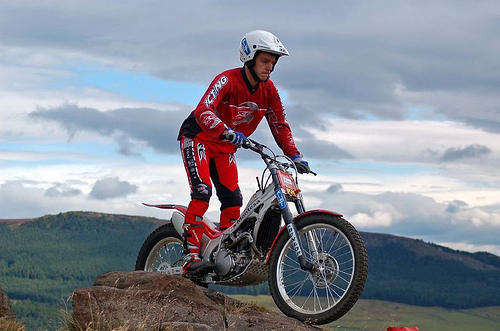

In [ ]:
# an image
load_img(f'/content/drive/MyDrive/Flicker8k_Dataset/{l[i][:-1]}')

In [ ]:
' '.join(res) # caption for above image

'man in a red shirt is riding a rock . <end>'

In [ ]:
# saving our encoder model

encoder.save('image_captioning_attention_encoder')

INFO:tensorflow:Assets written to: image_captioning_attention_encoder/assets


In [ ]:
# saving our decoder model

decoder.save_weights('image_captioning_attention_decoder')